# Import Modules and Twitter dataset from API

In [19]:
import DAL
import re
wishes_labelled = DAL.create("wishes-labelled")
wishes_list = wishes_labelled.subsets()



# I randomly split the whole data set into train and test data set

In [20]:

import random as rnd
n = len(wishes_list)
nweek = n/7
b = n/nweek
nn = 0
ntrain = []
for i in range(n):
    i = i+1 
    if i%b == 0:
        ntrain.extend(rnd.sample(range(nn*b,i), 1))
        nn += 1

ntest = list(set(range(n))-set(ntrain))

train_wishes = [wishes_list[i] for i in ntrain]
test_wishes = [wishes_list[i] for i in ntest]



# And extract the features from train data set as a dictionary

In [28]:
import DAL
import re
wishes_labelled  = DAL.create("wishes-labelled")
temp_dict = {}
j = 0 

for i in range(len(train_wishes)):
    text = ""
    ntweet = 0
    
    for tweet in wishes_labelled.iter(train_wishes[i]): 
        if tweet.has_key('text'):
            lower_text = tweet['text'].lower()
            text += lower_text
            ntweet += 1 


        else:
            break
            
        if ntweet >= 10000:

            break   
            
    text = re.sub(r'@[a-zA-Z0-9_]+', "", text) #removes the name of poster and the name after @ 
    text = re.sub(r'[^\x00-\x7F]', "", text) #removes consecutive non-ASCII characters
    text = re.sub(r'&[a-zA-Z0-9_]+', "", text)#removes puntuation with digits and words
    text = re.sub(r'\W', " ", text) #removes anything which is not alphanumeric
    text = re.sub(r'[0-9]', "", text) #removes #s
    text = re.sub(r"\s+", " ", text) #removing white space
    text = text.split(None)
    
    for word in text:
        if len(word) > 1:
            if temp_dict.has_key(word):
                temp_dict[word] = temp_dict[word]+1
            else:
                temp_dict.setdefault(word, 1)

mydict = []
for words in temp_dict.keys():
    if temp_dict[words] > 25:
        mydict.append(words)



2106
10000


Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object iter at 0x327a2d0> ignored


In [30]:
print "the total words in the dictionary I build would be", len(mydict)

the total words in the dictionary I build would be 570


#The feature vector in this case is a binary vector of {0, 1} with the same length of the dictionary, if the tweet has the word in the dictionary. Then the corresponding position of that word in the feature vector would be 1, otherwise the entries in the feature vector are all 0. The way I build the dictionary is randonmly choosing a day from everyweek in the data set given by, which would ensure the completeness of the dictionary. And I let other day of tweets in the data set become "test data". I would only go througn stochastic gradient descent for the "test data". 

# Then I come up with the function for stochastic gradient decent with different learning rate

In [ ]:
def learning_rate(x, ncount):
    import math
    if x == 0:
        return 0.1
    elif x == 1.0:
        return 0.5
    elif x == 2.0:
        return 1.0
    ##
    elif x == 3:
        return 0.3/ncount
    elif x == 4:
        return 1.0/ncount
    elif x == 5:
        return 2.0/ncount
    ##
    elif x == 6:
        return 0.3/math.sqrt(ncount)
    elif x == 7:
        return 1.0/math.sqrt(ncount)
    elif x == 8:
        return 5.0/math.sqrt(ncount)
    
    else:
        return 1

    
def str_eta(x):
    import math
    if x == 0:
        return str(0.1)
    elif x == 1.0:
        return str(0.5)
    elif x == 2.0:
        return str(1.0)
    ##
    elif x == 3:
        return '0.3/t'
    elif x == 4:
        return '1/t'
    elif x == 5:
        return '2/t'
    ##
    elif x == 6:
        return '0.3/sqrt(t)'
    elif x == 7:
        return '1/sqrt(t)'
    elif x == 8:
        return '5/sqrt(t)'
    
    else:
        return "1"    
    
def L2_regulation(label, mu, x, BETA, BETA0, eta, rambda):
    import numpy as np
    import math
    new_BETA0 = 0
    new_BETA = np.zeros(len(BETA))
    pi = np.exp(mu)/ (1 + np.exp(mu))
    new_BETA0 = BETA0 + eta*((label - pi) - rambda)
    new_BETA = BETA + eta * ((label - pi)* x - rambda)
    return (new_BETA0,new_BETA)
    
    
def L2_online_update( BETA, BETA0, ncount):
    import numpy as np
    import math
    import DAL
    errors = np.zeros(9)
    wishes_labelled = DAL.create("wishes-labelled")
    rambda = 0.001
    
    
    for k in xrange(L):
        temp = tweet_bunch[k]['text']
        temp = re.sub(r'@[a-zA-Z0-9_]+', "", temp)
        temp = re.sub(r'[^\x00-\x7F]', "", temp)
        temp = re.sub(r'&[a-zA-Z0-9_]+', "", temp)
        temp = re.sub(r'\W', " ", temp)
        temp = re.sub(r'[0-9]', "", temp)
        temp = temp.lower()
        temp = re.sub(r"\s+", " ", temp) 
        temp = temp.split()
    
        x = np.zeros(M)
            
        for word in temp:
            if word in mydict:
                temp_index = mydict.index(word)
                x[temp_index] = 1
                
        mu = np.dot(x,BETA) + BETA0  
        pi  = np.exp(mu)/ (1 + np.exp(mu))
        y_predict = np.zeros(9)
        
        for j in range(9):
            if pi[j] > 0.5:
                y_predict[j] = 1
        
        
        if tweet_bunch[k]['label'] != '?':
            y_origin = int(tweet_bunch[k]['label'])
            for j in range(9):
                
                if y_predict[j] != y_origin:
                    errors[j] = errors[j] + 1
                else:
                    pass 
            
            ncount = ncount + 1
            eta = [learning_rate(j, ncount) for j in range(9)]

    
            for j in range(9):
                update_BETA = L2_regulation(y_origin, mu[j], x, BETA[:,j], BETA0[j], eta[j], rambda)
            
                BETA0[j] = update_BETA[0]
                BETA[:,j] = update_BETA[1]
            
    
                
        else: ## for unlabeled data
            for j in range(9):
                unlabelled_dict[j].setdefault(tweet_bunch[k]['id'], str(int(y_predict[j])))
     
    
    return [BETA, BETA0, ncount, errors]





# Plot the error rate with every 1,000 tweets in order to examine our model

{274752462236299264: '0', 274753110809931776: '0', 274806657198985218: '0', 274860358081069059: '0', 274790945382354944: '0', 274945019981488128: '0', 274825159364444160: '0', 274759789433720833: '0', 274806730431545346: '0', 274791674151043073: '0', 274847433215840256: '0', 274883884087386115: '0', 274794934186426368: '0', 274815304922718208: '0', 274978171961618432: '0', 274994805300424705: '0', 274837087851794432: '0', 274798678915559424: '0', 275006390819491845: '0', 274824867763847168: '0', 274827818075033601: '0', 274869822951653377: '0', 274811149143388160: '0', 274854890860343296: '0', 274977271083835392: '0', 274870857296384000: '0', 274970973390905345: '0', 274960638881701888: '0', 275076587140038657: '0', 274875595098292226: '0', 275095985850572800: '0', 274796766187102208: '0', 274985085613244416: '0', 274834560829763585: '0', 274802037760352257: '0', 275032118256607232: '0', 275092961891602433: '1', 274820742535852032: '0', 274974081529561089: '0', 275002745126273024: '0',

Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object iter at 0x49b2a00> ignored
Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object iter at 0x49b2a00> ignored
Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object iter at 0x49b2a00> ignored
Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object iter at 0x49b2a00> ignored
Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object iter at 0x49b2a00> ignored
Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object iter at 0x49b2a00> ignored
Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object iter at 0x49b2a00> ignored
Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object iter at 0x49b2a00> ignored
Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object iter at 0x49b2a00> ignored
Exception RuntimeError: 'generator ignored Gen

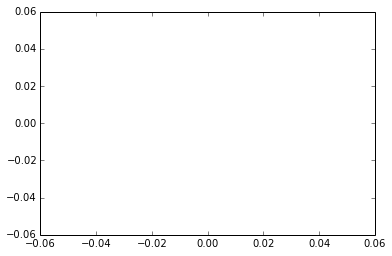

The coressponding error rate for unlabelled tweets is 

ValueError: Can only evaluate performance on the cluster.

In [36]:
import numpy as np
import matplotlib.pyplot as plt



M = len(mydict)
BETA = np.zeros((M,9))
BETA0 = np.zeros(9)
unlabelled_dict = [dict() for i in range(9)]

    
error_rate_temp = [ [] for i in range(9) ]
total_errors = np.zeros(9)
ncount = 0
temp_ncount = 0
tweet_bunch = []


for wishes in test_wishes: 
    for tweet in wishes_labelled.iter(wishes):
        tweet_bunch.append(tweet)
        if tweet['label'] != "?":
            ncount += 1
            
            
            if ncount%1000 == 0: # for every 1000 labelled tweet
                L = len(tweet_bunch) 
                result = L2_online_update(BETA, BETA0, temp_ncount)
                BETA = result[0]
                BETA0 = result[1]
                temp_ncount = result[2]
                total_errors = total_errors + result[3]
            
            
                for j in range(9):
                    error_rate_temp[j].append(total_errors[j] / temp_ncount)
                
                tweet_bunch = []            
        else:
            pass


        
L = len(tweet_bunch)
result = L2_online_update(BETA, BETA0, temp_ncount)
BETA = result[0]
BETA0 = result[1]
temp_ncount = result[2]    
total_errors = total_errors + result[3]
        

for j in range(9):
    eta = str_eta(j)
    print "learning rate is " + eta 
    fig = plt.figure(j)
    plt.plot(range(int(ncount / 1000)), error_rate_temp[j]) 
    plt.show()
    print 'The coressponding error rate for unlabelled tweets is ',(wishes_labelled.eval(unlabelled_dict[j]))

    